In [18]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [19]:
def branin(X, Y):
    return -(20 * (1 - np.exp(-0.2 * np.sqrt(0.5 * (X**2 + Y**2)))) - np.exp(0.5 * (np.cos(2 * np.pi * X) + np.cos(2 * np. pi * Y))) + np.exp(1))


In [20]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [21]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, a, b: 0.1*(a - 4) * x + 0.05*(b + 3) * x**2 + r.normal(0, sim_stdev)

In [22]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-35, 35, 10)
Y = np.random.uniform(-35, 35, 10)

# Calculate the outputs using Branin and Currin functions
output1 = branin(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [23]:
sim_eval = lambda x, y, a, b: branin(x, y) + sim_err(x, a, b)

In [24]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (2,5)},
          {'name': 'b', 'type': 'continuous', 'domain': (-4,-1)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.98746321 -2.99734961]


In [25]:
df

,x,y,z,a,b,sim_z,diff
0,-5.808460,-5.656384,-15.447675,3.987463,-2.99735,-14.560038,-0.887637
1,15.422715,12.965365,-20.539782,3.987463,-2.99735,-23.885836,3.346054
2,-34.991994,-20.688343,-21.311133,3.987463,-2.99735,-19.221371,-2.089762
3,-13.836720,26.468221,-21.753684,3.987463,-2.99735,-19.869969,-1.883714
4,-24.727088,-33.082868,-21.133971,3.987463,-2.99735,-18.947204,-2.186767
5,-28.536298,11.932726,-21.439708,3.987463,-2.99735,-19.218723,-2.220985
6,-21.961785,-5.788664,-20.096030,3.987463,-2.99735,-17.862085,-2.233945
7,-10.810749,4.108288,-17.005695,3.987463,-2.99735,-15.560290,-1.445405
8,-7.226277,-25.172914,-20.852178,3.987463,-2.99735,-19.786550,-1.065629
9,2.717171,-21.132896,-20.500723,3.987463,-2.99735,-20.944554,0.443831


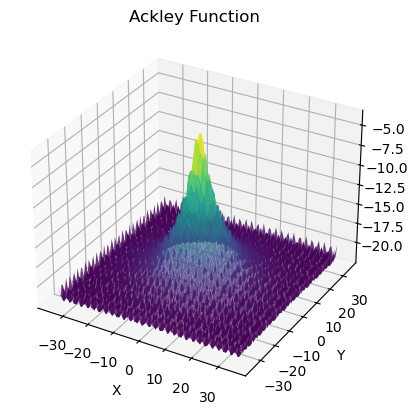

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-35, 35, 100)
y_range = np.linspace(-35, 35, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = branin(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ackley Function')

# Show the plot
plt.show()

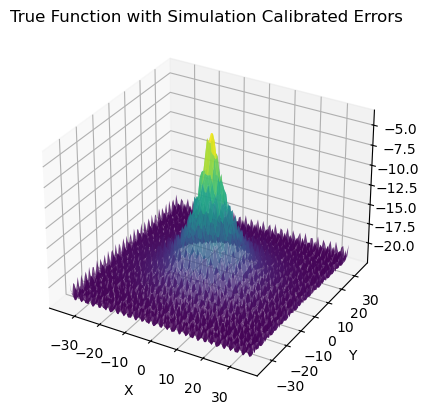

In [27]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [28]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [29]:
def perform_iteration(df):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-35, 35, 100)
    x2_range  = np.linspace(-35, 35, 100)

    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    x_grid_scaled = scaler_x.transform(x_grid)

    # Perform MC Dropout predictions for entire meshgrid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid_scaled)

    # Define range for inputs
    bounds = np.array([[-35, 35], [-35, 35]])

    # Identify top 10 points with highest uncertainty
    num_new_points = 10

    sampler = qmc.LatinHypercube(d=2)  # LHS in a 2D space
    lhs_sample = sampler.random(n=100)
    lhs_points = qmc.scale(lhs_sample, bounds[:, 0], bounds[:, 1])

    lhs_mean, lhs_std = mc_dropout_predictions(best_model, lhs_points)
    percentile_threshold = 90 
    threshold_value = np.percentile(lhs_mean, percentile_threshold)

    # Filter points above the threshold
    points_above_threshold = lhs_points[lhs_mean >= threshold_value]

    num_new_points = 10
    if len(points_above_threshold) > num_new_points:
        selected_indices = np.random.choice(len(points_above_threshold), num_new_points, replace=False)
        selected_points = points_above_threshold[selected_indices]
    else:
        selected_points = points_above_threshold

    new_points_df = pd.DataFrame(selected_points, columns=['x','y'])

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot the high uncertainty points
    ax.scatter(selected_points[:, 0], selected_points[:, 1], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    # Add validated data points to original data frame
    new_points_df["z"] = branin(new_points_df['x'], new_points_df['y']) + ran_err(num_new_points, 0.05)
    new_points_df["a"] = bo.x_opt[0]
    new_points_df["b"] = bo.x_opt[1]
    new_points_df["sim_z"] = sim_eval(new_points_df["x"], new_points_df["y"], new_points_df["a"], new_points_df["b"])
    new_points_df["diff"] = new_points_df["z"] - new_points_df["sim_z"]

    df = pd.concat([df, new_points_df], axis=0, ignore_index=True)
    return df


Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.02952137196617147
dropout_rate: 0.0
batch_size: 75
epochs: 62
Epoch 1/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step - loss: 362.4466
Epoch 2/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 311.2354
Epoch 3/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 250.2649
Epoch 4/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 172.4914
Epoch 5/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 89.6528
Epoch 6/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.6459
Epoch 7/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 47.1884
Epoch 8/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 90.7175
Epoch 9/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 81.2090
Epoch 10/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 44.5652
Epoch 11/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 17.3530
Epoch 12/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.1376
Epoch 13/62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 16.1082
Epoch 14/62
1/1 ━

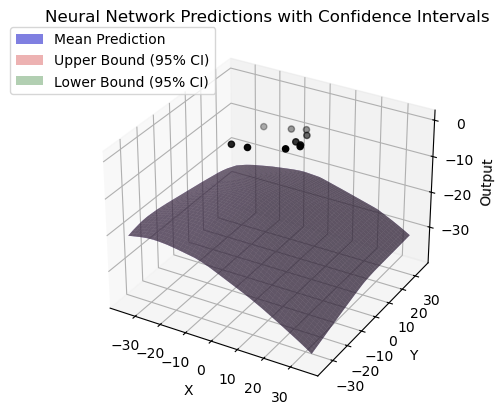

In [30]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.03507117955559006
dropout_rate: 0.0
batch_size: 123
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step - loss: 323.6379
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 267.9348
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 197.6913
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 111.7731
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 35.6802
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.0284
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 87.9625
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 79.8948
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 40.2915
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 15.6597
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 14.0433
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 23.8621
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 33.5284
Ep

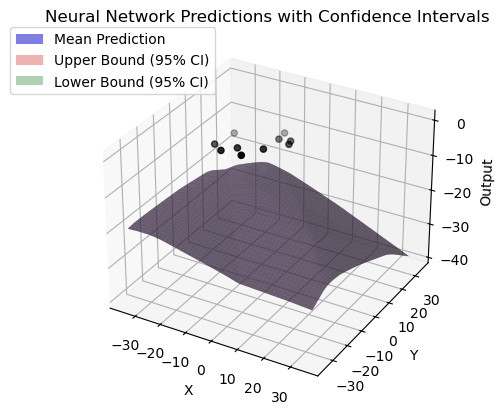

In [31]:
df = perform_iteration(df)

In [32]:
df

,x,y,z,a,b,sim_z,diff
0,-5.808460,-5.656384,-15.447675,3.987463,-2.99735,-14.560038,-0.887637
1,15.422715,12.965365,-20.539782,3.987463,-2.99735,-23.885836,3.346054
2,-34.991994,-20.688343,-21.311133,3.987463,-2.99735,-19.221371,-2.089762
3,-13.836720,26.468221,-21.753684,3.987463,-2.99735,-19.869969,-1.883714
4,-24.727088,-33.082868,-21.133971,3.987463,-2.99735,-18.947204,-2.186767
5,-28.536298,11.932726,-21.439708,3.987463,-2.99735,-19.218723,-2.220985
6,-21.961785,-5.788664,-20.096030,3.987463,-2.99735,-17.862085,-2.233945
7,-10.810749,4.108288,-17.005695,3.987463,-2.99735,-15.560290,-1.445405
8,-7.226277,-25.172914,-20.852178,3.987463,-2.99735,-19.786550,-1.065629
9,2.717171,-21.132896,-20.500723,3.987463,-2.99735,-20.944554,0.443831


Best hyperparameters:
num_layers: 4
num_units: 108
learning_rate: 0.04077499365367614
dropout_rate: 0.22497499495561385
batch_size: 100
epochs: 185
Epoch 1/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 308.1729
Epoch 2/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 43.8557
Epoch 3/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 222.9260
Epoch 4/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 155.0368
Epoch 5/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 76.5661
Epoch 6/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 25.8880
Epoch 7/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 34.1300
Epoch 8/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 29.5072
Epoch 9/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 28.0892
Epoch 10/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 28.4111
Epoch 11/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 33.8940
Epoch 12/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 41.5860
Epoch 13/185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - los

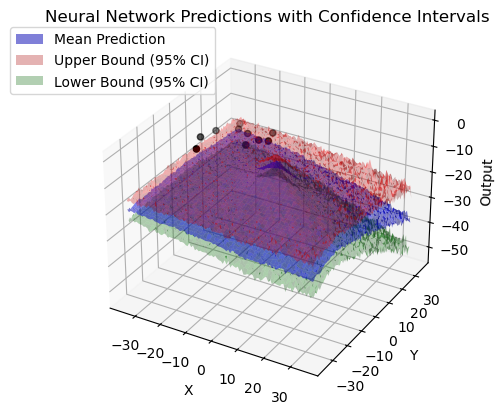

In [33]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step - loss: 296.5391
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 121.6376
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 92.7296
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 28.6889
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 34.4946
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 38.6325
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 22.4066
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 17.1582
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.9738
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 19.2027
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.8519
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 18.9743
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 19.8733
Epoch 14/200
1/1 ━━━

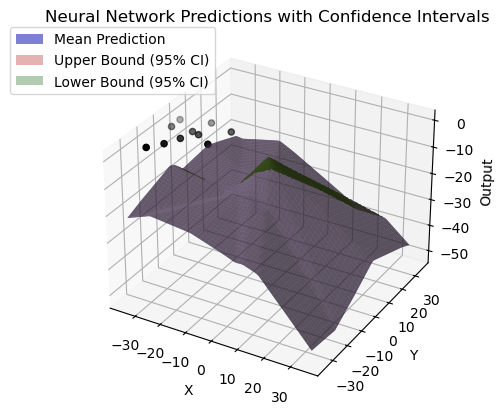

In [34]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.013709791055563568
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step - loss: 334.5624
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 282.2439
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 222.0894
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 145.3438
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 71.7447
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 46.5500
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 92.5621
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 101.6396
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 68.7289
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 38.6631
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 29.3882
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 34.6703
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 42.7455

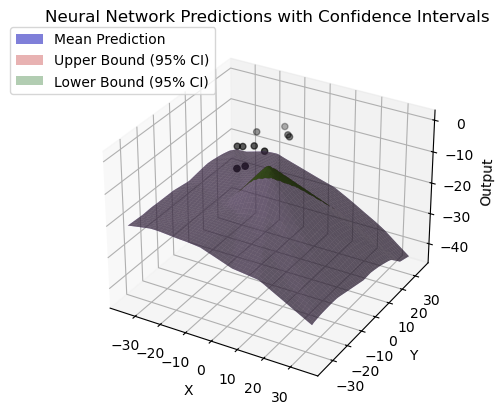

In [35]:
df = perform_iteration(df)